In [138]:
import torch 
import gpytorch
import config_safeopt as cfg
from GPTrainer import GPTrainer
import math
import gp_config as gp_cfg    
from beta import beta_srinivas09 as beta
train_x = cfg.INITIAL_X
train_y = cfg.INITIAL_Y
%load_ext autoreload 
%autoreload 2
# gp_trainer = GPTrainer(gp_cfg, train_x, train_y)

C_lower = torch.full_like(cfg.DOMAIN.flatten(), -1e9)
C_upper = torch.full_like(cfg.DOMAIN.flatten(), 1e9)
C_lower[cfg.INITIAL_SAFE_INDICES] = cfg.SAFETY_THRESHOLD
    
S_mask = torch.zeros(cfg.N_POINTS, dtype=torch.bool)
S_mask[cfg.INITIAL_SAFE_INDICES] = True
    
# Pre-compute pairwise distances for the discrete domain D
distance_matrix = torch.cdist(cfg.DOMAIN, cfg.DOMAIN) 

gp_trainer = GPTrainer(gp_cfg, train_x, train_y)
gp_trainer.train()
train_x = [] 
train_y = []           


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Iter 1/25 - Loss: 0.490   noise: 0.066   Length_scale: 0.693   output_scale: 0.693
Iter 2/25 - Loss: 0.390   noise: 0.055   Length_scale: 0.798   output_scale: 0.598
Iter 3/25 - Loss: 0.318   noise: 0.045   Length_scale: 0.909   output_scale: 0.513
Iter 4/25 - Loss: 0.276   noise: 0.037   Length_scale: 1.020   output_scale: 0.437
Iter 5/25 - Loss: 0.237   noise: 0.031   Length_scale: 1.127   output_scale: 0.371
Iter 6/25 - Loss: 0.188   noise: 0.026   Length_scale: 1.224   output_scale: 0.313
Iter 7/25 - Loss: 0.136   noise: 0.023   Length_scale: 1.308   output_scale: 0.262
Iter 8/25 - Loss: 0.095   noise: 0.020   Length_scale: 1.375   output_scale: 0.219
Iter 9/25 - Loss: 0.068   noise: 0.019   Length_scale: 1.427   output_scale: 0.182
Iter 10/25 - Loss: 0.032   noise: 0.019   Length_scale: 1.464   output_scale: 0.151
Iter 11/25 - Loss: -0.024   noise: 0.020   Length_scale: 1.491   output_scale: 0.

In [139]:
i = 1

In [178]:

# gp_trainer.train_s(train_x, train_y)
print("l_scale --" ,gp_trainer.model.covar_module.base_kernel.lengthscale.item())
print("output scale  -- " ,gp_trainer.model.covar_module.outputscale)

mean, std_dev = gp_trainer.get_posterier(cfg.DOMAIN)

beta_t_sqr = math.sqrt(beta(i,cfg.N_POINTS,gp_trainer.model.likelihood.noise.item(),gp_trainer.model.covar_module.outputscale))

Q_lower = mean - beta_t_sqr * std_dev
Q_upper = mean + beta_t_sqr * std_dev
Q_lower = mean - cfg.BETA * std_dev
Q_upper = mean + cfg.BETA * std_dev


C_lower = torch.max(C_lower, Q_lower) 
C_upper = torch.min(C_upper,Q_upper)
C_lower = Q_lower
C_upper = Q_upper

S_prev_indices = torch.where(S_mask)[0]
new_S_mask = S_mask.clone()
for s_idx in S_prev_indices:
    # set of indicies for all points that are lipschitz safe relative to x[s_idx]
    lipschitz_safe = C_lower[s_idx] - cfg.LIPSCHITZ_CONSTANT * distance_matrix[s_idx] >= cfg.SAFETY_THRESHOLD
    new_S_mask = torch.logical_or(new_S_mask, lipschitz_safe)
S_mask = new_S_mask

if not torch.any(S_mask):
    print(f"Iteration {i+1}: Safe set is empty. Stopping.")
    

wt_D = C_upper - C_lower
wt_S = torch.full_like(wt_D, -1e9)
wt_S[S_mask] = wt_D[S_mask]

xt = cfg.DOMAIN[torch.argmax(wt_S)]
yt = cfg.ground_truth(xt) + torch.randn(1) * 0.2 # 

# print (train_y.shape, yt.unsqueeze(0).shape , yt.shape)
# print(train_x.shape, xt.unsqueeze(0).shape , train_y.shape, yt.shape)
if len(train_x) == 0 :
    train_x = xt.unsqueeze(0)
    train_y = yt 
else :
    train_x = torch.cat([train_x, xt.unsqueeze(0)])
    train_y = torch.cat([train_y, yt])

print(f"Final train set size : {len(train_x)} \n Final safe set = {torch.where(S_mask)[0].tolist()}")

gp_trainer = GPTrainer(gp_cfg, train_x, train_y)
gp_trainer.train()
i+=1

l_scale -- 0.23866811394691467
output scale  --  tensor(1.7390, grad_fn=<SoftplusBackward0>)
Final train set size : 34 
 Final safe set = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
Iter 1/25 - Loss: 0.786   noise: 0.032   Length_scale: 0.693   output_scale: 0.693
Iter 2/25 - Loss: 0.421   noise: 0.039   Length_scale: 0.598   output_scale: 0.798
Iter 3/25 - Loss: 0.199   noise: 0.046   Length_scale: 0.514   output_scale: 0.910
Iter 4/25 - Loss: 0.084   noise: 0.051   Length_scale: 0.442   output_scale: 1.025
Iter 5/25 - Loss: 0.033   noise: 0.055   Length_scale: 0.382   output_scale: 1.136
Iter 6/25 - Loss: 0.014   noise: 0.056   Length_scale: 0.334   output_scale: 1.240
Iter 7/25 - Loss: 0.009   noise: 0.055   Length_scale: 0.295   output_scale: 1.336
Iter 8/25 - Loss: 0.008   noise: 0.053   Length_scale: 0.265   output_scale: 1.423
Iter 9/25 - Loss: 0.008   noise: 0.049   Length_scale: 0.241   output_scale: 1.500
Iter 10/25 - Loss: 0.007

In [141]:
beta_t_sqr

1688.3894825851758

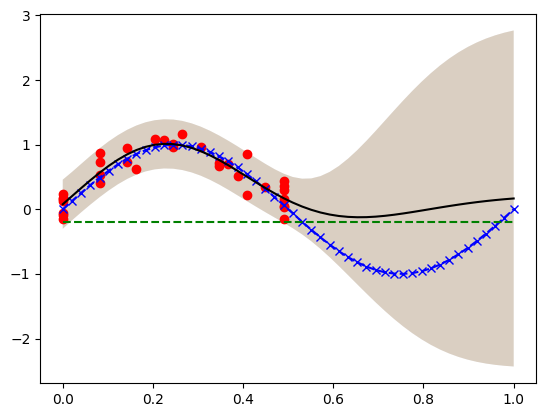

In [179]:
import matplotlib.pyplot as plt

plt.plot(train_x.numpy(), train_y.numpy(), 'ro', label='Training Data')
plt.plot(cfg.DOMAIN.numpy(), cfg.ground_truth(cfg.DOMAIN).numpy(), 'bx--', label='Ground Truth')
plt.plot(cfg.DOMAIN.numpy(), mean.numpy(), 'k-', label='GP Mean')
plt.plot(cfg.DOMAIN.numpy(), cfg.SAFETY_THRESHOLD * torch.ones_like(cfg.DOMAIN).numpy(), 'g--', label='Safety Threshold')
plt.fill_between(cfg.DOMAIN.numpy().flatten(), C_lower.numpy(), C_upper.numpy(), alpha=0.2, label='C Bounds')
plt.fill_between(cfg.DOMAIN.numpy().flatten(), Q_lower.numpy(), Q_upper.numpy(), alpha=0.2, label='C Bounds')